# Multioutput GP toolbox example

Dataset consisting 

In [1]:
# execute if not installed
import sys
sys.path.insert(0, '../')

import mogptk

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

%reload_ext autoreload
%autoreload 2

In [2]:
# plot config
sns.set_context('paper', font_scale=1.3)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 5)

# MOGP prediction on the sensor values

We use the 9 sensor values as channels, giving 9 channels in total.

All the data is sampled at 60Hz. With 500 samples (~8.3 segs) for each file.

In [3]:
def plot_experimet(model, ylims=None, title='Smartphone experiment'):
    """
    Plot smartphone mogptk example
    """
    x_train = model.data.X
    y_train = model.data.Y
    x_all = model.data.X_all
    y_all = model.data.Y_all
    x_pred = {i:array for i, array in enumerate(data.X_all)}
    
    try:
        x_pred, mean_pred, var_pred = model.predict(x_pred)
    except:
        pass
    
    names = ['Acc_x',
             'Acc_y',
             'Acc_z',
             'Gyr_x',
             'Gyr_y',
             'Gyr_z',
             'Mag_x',
             'Mag_y',
             'Mag_z']
    
    f, axarr = plt.subplots(3, 3, sharex=True, figsize=(15, 10))
    axarr = axarr.reshape(-1)
    
    for i in range(9):
        axarr[i].plot(x_train[i], y_train[i], '.k', label='Train')
        axarr[i].plot(x_all[i], y_all[i], '--', label='Test', c='gray')
        try:
            axarr[i].plot(x_pred[i], mean_pred[i], label='Test', c=sns.color_palette()[i])
            axarr[i].fill_between(x_pred[i].reshape(-1),
                                  mean_pred[i] + 2 * np.sqrt(var_pred[i]),
                                  mean_pred[i] - 2 * np.sqrt(var_pred[i]),
                                  label='95% c.i',
                                  color=sns.color_palette()[i],
                                  alpha=0.4)
        except:
            pass
        axarr[i].legend(ncol=2)
        axarr[i].set_title(names[i])
    plt.suptitle(title, y=1.02)
    plt.tight_layout()

In [4]:
df = pd.read_csv('data/HAR/Smartphone_Dataset/S01/bike1.csv', header=None)

# get values
y = df.values

# generate time values
t = (np.arange(0, 500) / 60).reshape(-1, 1)

In [5]:
# data container
data = mogptk.Data()

# add data to container
for channel in range(9):
    data.add(t, y[:, channel])
    
# check outdims
print('Input dims:', data.get_input_dims())
print('Number of channels:', data.get_output_dims())

Input dims: 1
Number of channels: 9


### Simulate sensor failure

In [6]:
# randomly sample from the data
for i in range(9):
    data.remove_randomly(channel=i, pct=0.7)
    
# drop chunks to simulate sensor failure
data.remove_range(0, None, 1)
data.remove_range(1, 0.5, 1.2)
data.remove_range(2, 6, None)
data.remove_range(3, 7, None)
data.remove_range(4, 7, None)
data.remove_range(6, 4, 4.5)
data.remove_range(7, 5, 6.1)

In [7]:
# define model
model = mogptk.MOSM(data, Q=5)

# initialize parameters with BNSE
model.init_params('full')

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -238.439842
  Number of iterations: 107
  Number of functions evaluations: 131
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -162.109508
  Number of iterations: 52
  Number of functions evaluations: 57
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -171.209579
  Number of iterations: 104
  Number of functions evaluations: 129
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -370.240302
  Number of iterations: 58
  Number of functions evaluations: 161
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 36.220149
  Number of iterations: 103
  Number o

Building...


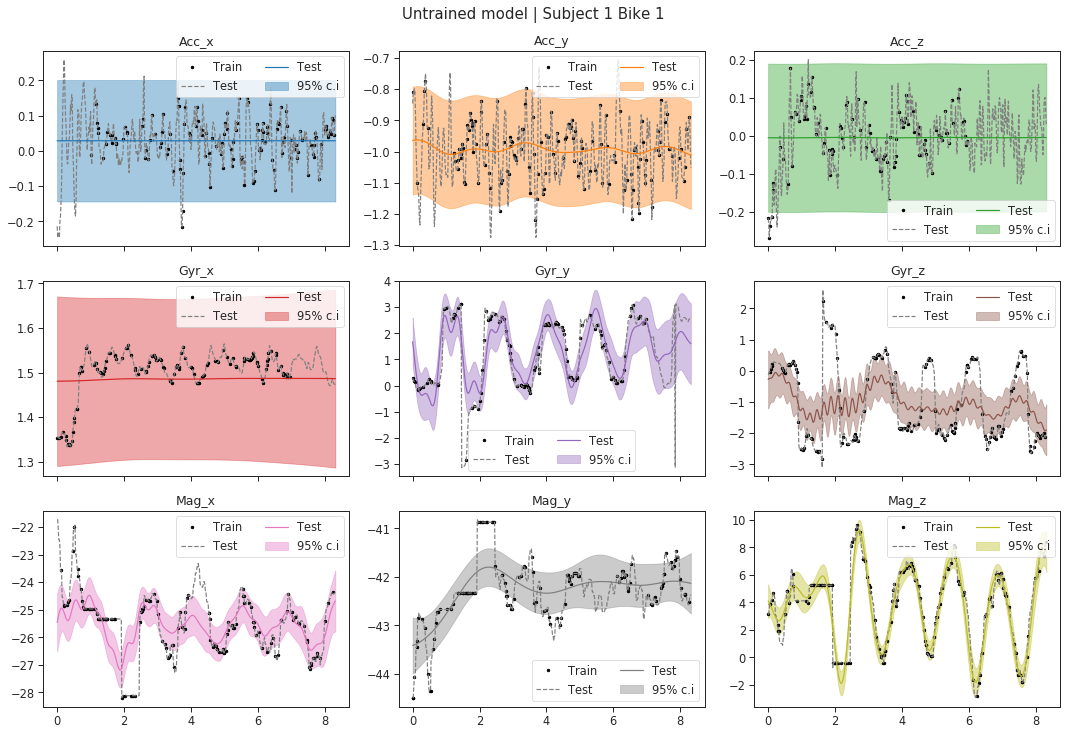

In [8]:
model.build()
plot_experimet(model, title='Untrained model | Subject 1 Bike 1')

In [9]:
%%time
# fit to data
model.train('L-BFGS-B', maxiter=5000, disp=True, tol=1e-15)

Building...
Optimizing...
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -145.515328
  Number of iterations: 5000
  Number of functions evaluations: 5766
Done
CPU times: user 50min 31s, sys: 4min 59s, total: 55min 30s
Wall time: 45min 48s


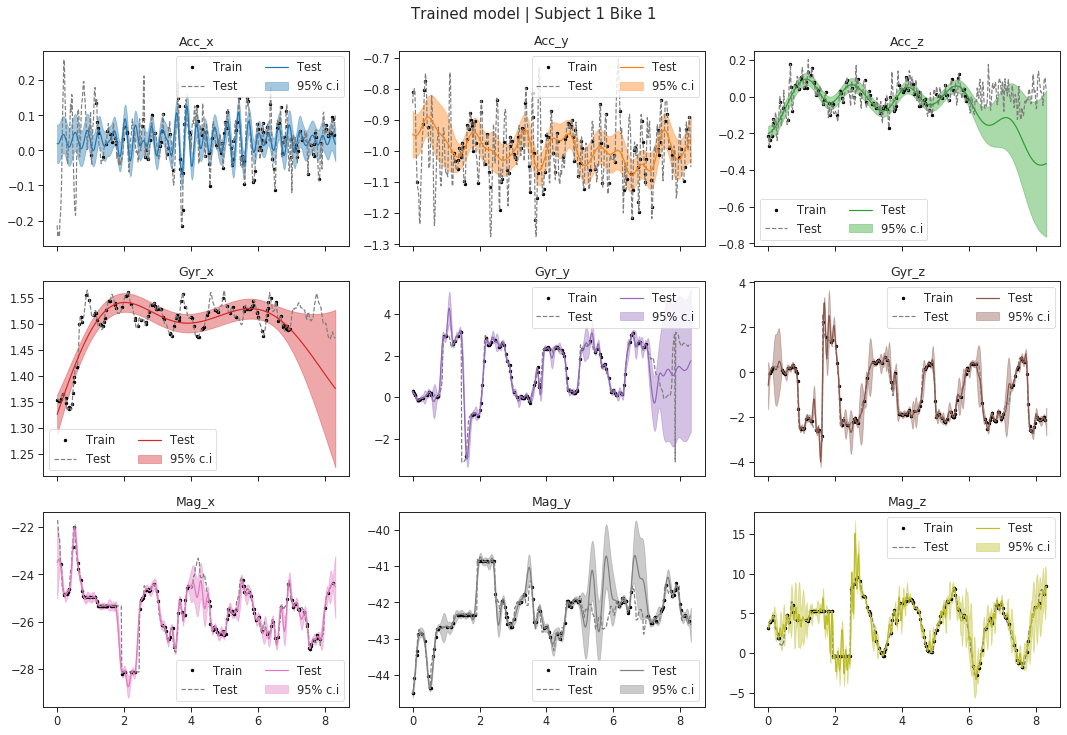

In [10]:
plot_experimet(model, title='Trained model | Subject 1 Bike 1')